# David Stanko
# Practical Homework 2

Research question:

How do the following predictors affect cancer and diabetes?
1. Age
2. Hours worked weekly
3. Alcohol consumption
4. Height
5. Weight
6. BMI

## Examine the dataset

In [226]:
import pandas as pd
import seaborn as sns

In [227]:
health_data = pd.read_csv("nhis_2022.csv")
health_data.head()

YEAR  SERIAL  STRATA  PSU         NHISHID  REGION  PERNUM  \
0  2022       1     143   16  0002022H000001       4       1   
1  2022       2     106   53  0002022H000003       3       1   
2  2022       2     106   53  0002022H000003       3       2   
3  2022       3     134   13  0002022H000006       2       1   
4  2022       4     106   53  0002022H000007       3       1   

            NHISPID      HHX  SAMPWEIGHT  ...  TOMSAUCEMNO  SODAPNO  FRIESPNO  \
0  0002022H00000110  H000001      8018.0  ...            2        0       110   
1  0002022H00000310  H000003     10117.0  ...            1        0         1   
2  0002022H00000320  H000003      7933.0  ...          996      996       996   
3  0002022H00000610  H000006      2681.0  ...            1        1         1   
4  0002022H00000710  H000007     10233.0  ...            3       30         5   

   SPORDRMNO  FRTDRINKMNO  COFETEAMNO  POTATONO  PIZZANO  HRSLEEP  CVDSHT  
0          3            0           0         3        2        8       1  
1          0            0           1         1        1        6       2  
2        996          996         996       996      996        0       2  
3          0            2           0         1        1        6       2  
4          1            0          30         6        2        8       2  

[5 rows x 48 columns]

In [228]:
health_data.shape

(35115, 48)

In [229]:
health_data.isna().sum()

YEAR           0
SERIAL         0
STRATA         0
PSU            0
NHISHID        0
REGION         0
PERNUM         0
NHISPID        0
HHX            0
SAMPWEIGHT     0
ASTATFLG       0
CSTATFLG       0
AGE            0
SEX            0
MARSTCUR       0
EDUC           0
HOURSWRK       0
POVERTY        0
HEIGHT         0
WEIGHT         0
BMICALC        0
HINOTCOVE      0
CANCEREV       0
CHEARTDIEV     0
DIABETICEV     0
HEARTATTEV     0
STROKEV        0
ALCANYNO       0
ALCDAYSYR      0
CIGDAYMO       0
MOD10DMIN      0
VIG10DMIN      0
FRUTNO         0
VEGENO         0
JUICEMNO       0
SALADSNO       0
BEANNO         0
SALSAMNO       0
TOMSAUCEMNO    0
SODAPNO        0
FRIESPNO       0
SPORDRMNO      0
FRTDRINKMNO    0
COFETEAMNO     0
POTATONO       0
PIZZANO        0
HRSLEEP        0
CVDSHT         0
dtype: int64

There are 35,115 rows and 48 columns. There is no missing data.

## Select the relevant variables

We will drop all the variables that we won't use. Note that there are two variables for alcohol use. We will keep one, which is the number of days a person drank alcohol in the past year.

In [230]:
# Get the indices of the columns we will keep. Concatenate the lists using the + operator
indices_to_keep = [12] + [16] + list(range(18, 21)) + [22] + [24] + [28]

# Keep only those columns
health_data = health_data.iloc[:, indices_to_keep]
health_data.head()

AGE  HOURSWRK  HEIGHT  WEIGHT  BMICALC  CANCEREV  DIABETICEV  ALCDAYSYR
0   61        45      69     260     38.4         1           1        104
1   43        45      70     190     27.3         1           1         52
2   12         0      60      96     18.7         0           1        996
3   68         0      75     200     25.0         1           1        364
4   73         0      71     172     24.0         1           1          0

## Rename columns for readability

In [231]:
health_data.rename(columns={"AGE": "age", "HOURSWRK": "hours_worked_weekly", 
                            "HEIGHT": "height", "WEIGHT": "weight", "BMICALC": "bmi",
                            "CANCEREV": "had_cancer", 
                            "DIABETICEV": "had_diabetes", 
                            "ALCDAYSYR": "days_used_alcohol_yearly",
                        }, inplace=True)

## Drop survey responses of "unknown"

Many of the responses to survey questions are "Unknown", and some people were not asked some questions. There are encodings for those responses - for example, for `hours_worked_weekly`, 0 indicates "Not in universe", 97 indicates "Unknown -- refused", 98 indicates "Unknown -- not ascertained", and 99 indicates "Unknown -- don't know". We will use these encodings to drop all the rows where at least one survey response is "Unknown". 

In [232]:
health_data = health_data.loc[~health_data["had_cancer"].isin([0, 7, 8, 9])]
health_data = health_data.loc[~health_data["had_diabetes"].isin([0, 7, 8, 9])]

health_data = health_data.loc[~health_data["age"].isin([997, 998, 999])]
health_data = health_data.loc[~health_data["height"].isin([0, 95, 96, 97, 98, 99])]
health_data = health_data.loc[~health_data["weight"].isin([0, 996, 997, 998, 999, 995])]
health_data = health_data.loc[~health_data["bmi"].isin([0, 996])]

health_data = health_data.loc[~health_data["hours_worked_weekly"].isin([0, 97, 98, 99])]
health_data = health_data.loc[~health_data["days_used_alcohol_yearly"].isin([995, 996, 997, 998, 999])]

health_data.reset_index(drop=True, inplace=True)

In [233]:
health_data.shape

(12671, 8)

Now we have only 12,671 samples. 

## Recode the class labels

We will recode the class labels from numerical variables to strings. For `had_cancer`, 1 represents "No" and 2 represents "Yes". However, `had_diabetes` has 3 classes. 1 represents "No", 2 represents "Yes", and 3 represents "Borderline". So, first let's make sure all 3 of those classes are there:

In [234]:
health_data["had_diabetes"].unique()

array([1, 2], dtype=int64)

Only the first two are there; there are no survey respondents with borderline diabetes. So, we can treat `had_diabetes` as a binary variable.

In [235]:
# Convert 1 and 2 to "No" and "Yes"
health_data["had_cancer"] = ["No" if class_label == 1 else "Yes" for class_label in health_data["had_cancer"]]
health_data["had_diabetes"] = ["No" if class_label == 1 else "Yes" for class_label in health_data["had_diabetes"]]

In [236]:
health_data.head()

age  hours_worked_weekly  height  weight   bmi had_cancer had_diabetes  \
0   61                   45      69     260  38.4         No           No   
1   43                   45      70     190  27.3         No           No   
2   29                   40      68     190  28.9         No           No   
3   69                   20      71     180  25.1        Yes           No   
4   59                   49      67     140  21.9         No           No   

   days_used_alcohol_yearly  
0                       104  
1                        52  
2                        12  
3                         3  
4                       364

## Standardize the data

Because SVMs are sensitive to scale, we will standardize all the predictors to have zero mean and a variance of 1.

In [237]:
from sklearn.preprocessing import StandardScaler

In [238]:
target_cols = ["had_cancer", "had_diabetes"] # Column names of both the target variables

# Remove the targets before standardization
X = health_data.drop(columns = target_cols)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # scaled predictors as a NumPy array

# Make a new DataFrame with the standardized predictors and the target
health_data_scaled = pd.DataFrame(X_scaled, columns = X.columns)
health_data_scaled[target_cols] = health_data[target_cols]

health_data_scaled.head()

age  hours_worked_weekly    height    weight       bmi  \
0  1.078206             0.351941  0.467147  2.015933  1.903779   
1 -0.161423             0.351941  0.727756  0.238412 -0.136969   
2 -1.125578            -0.029182  0.206538  0.238412  0.157193   
3  1.629152            -1.553675  0.988365 -0.015519 -0.541442   
4  0.940470             0.656840 -0.054072 -1.031246 -1.129765   

   days_used_alcohol_yearly had_cancer had_diabetes  
0                  0.363589         No           No  
1                 -0.200195         No           No  
2                 -0.633875         No           No  
3                 -0.731453        Yes           No  
4                  3.182511         No           No

## EDA

### What's the class distribution?

In [239]:
for target_col in target_cols:
    print(f"\n{health_data_scaled[target_col].value_counts(normalize=True).round(4)}")


had_cancer
No     0.9306
Yes    0.0694
Name: proportion, dtype: float64

had_diabetes
No     0.9392
Yes    0.0608
Name: proportion, dtype: float64


Both target variables have extreme class imbalance. 93.06% of survey respondents have not had cancer, and only 6.94% have. 93.92% of respondents have not had diabetes, and 6.08% have. So, our models will most likely perform very well for predicting respondents who have *not* had these health conditions, and perform very badly for respondents who have. 

### Are the classes linearly separable, or is a nonlinear kernel better?

Now we'll see the classes are linearly separable for both cancer and diabetes. That will determine which predictors and target are better suited for a linear kernel, and which are better suited for a nonlinear one. We will make a different dataset for each health condition, with each one having only that condition as the target.

In [240]:
cancer_data = health_data_scaled.drop(columns = {"had_diabetes"})
diabetes_data = health_data_scaled.drop(columns = {"had_cancer"})

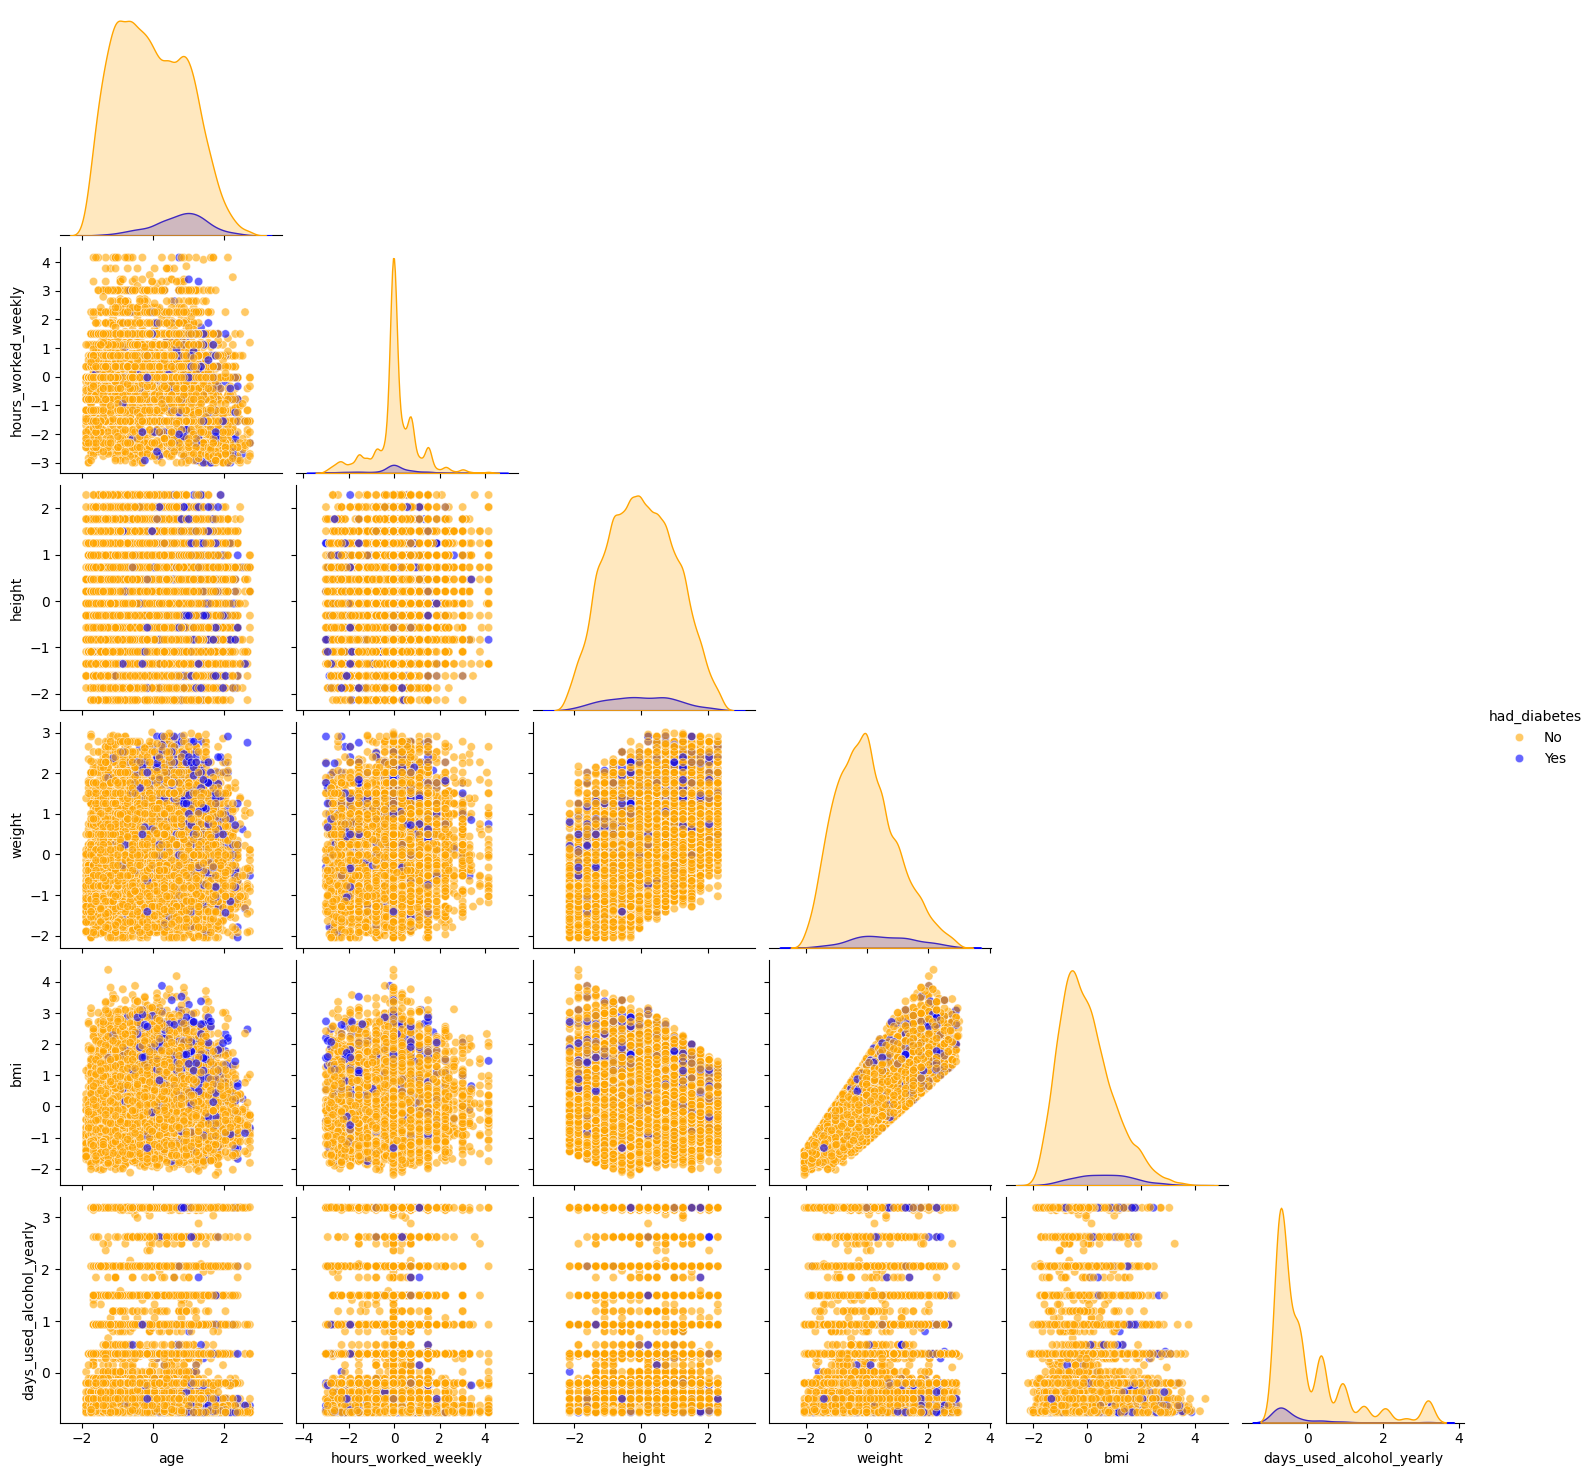

In [241]:
sns.pairplot(data = diabetes_data, hue = "had_diabetes", plot_kws={"alpha": 0.6}, corner = True, palette=["orange", "blue"])

All the plots have significant overlap between the classes. The blue data points (for respondents who have had diabetes) are right in the middle of the orange data points (respondents who haven't). There is no boundary between the classes, so we can already tell that SVMs wouldn't be a good classifier. But, even with the overlap, `weight`, `age`, and `bmi` seem to be the strongest predictors for whether someone has had diabetes. 

Looking at the `bmi` vs. `age` plot, people who've had diabetes tend to have a higher BMI or tend to be older. Looking at `weight` vs. `age`, people with a higher weight, as well as older people, are more likely to have had diabetes. Looking at `age` vs. `hours_worked_weekly`, people on the medium or high part of the age range have had diabetes. For `bmi` vs. `height`, people with a high BMI have had diabetes. `bmi` and `weight` have a strong positive relationship, and people with a higher BMI and a higher weight have had diabetes.

Let's zoom in on these plots:

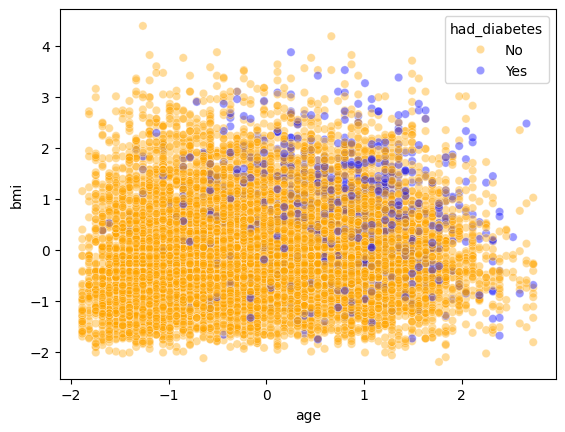

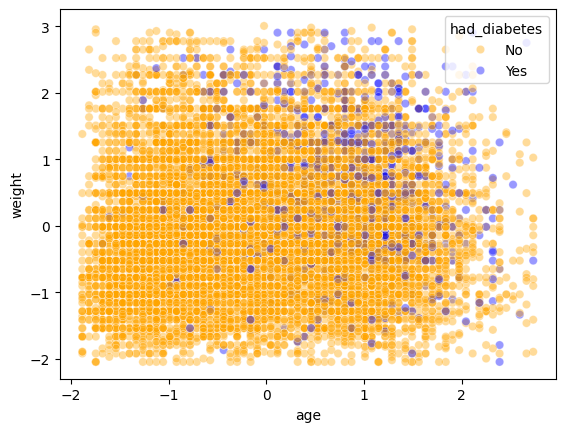

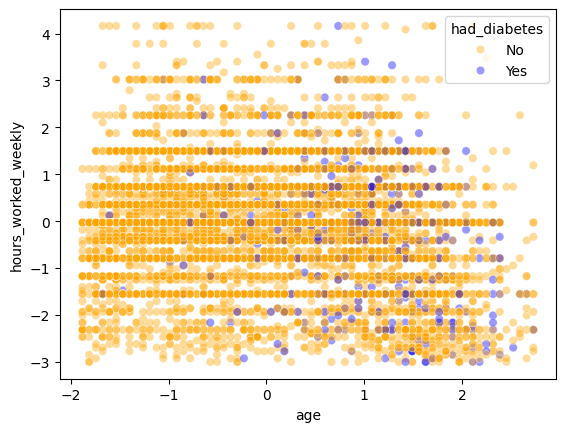

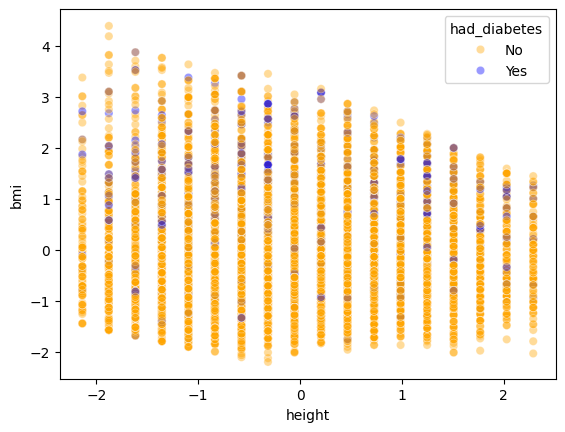

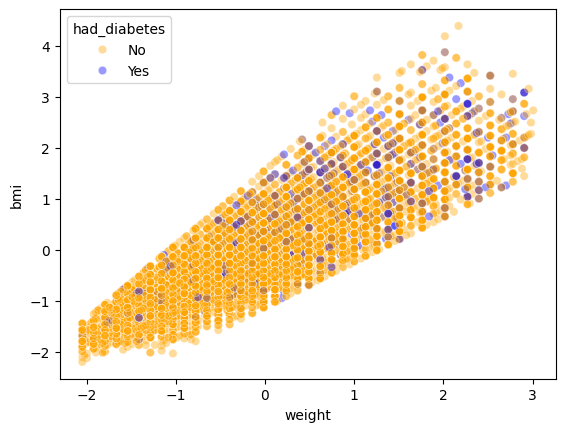

In [242]:
import matplotlib.pyplot as plt

sns.scatterplot(diabetes_data, x = "age", y = "bmi", hue = "had_diabetes", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(diabetes_data, x = "age", y = "weight", hue = "had_diabetes", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(diabetes_data, x = "age", y = "hours_worked_weekly", hue = "had_diabetes", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(diabetes_data, x = "height", y = "bmi", hue = "had_diabetes", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(diabetes_data, x = "weight", y = "bmi", hue = "had_diabetes", palette = ["orange", "blue"], alpha=0.4)
plt.show()

Based on the plots above, I conclude that a linear kernel would be good for separating `bmi` and `age`, as well as `weight` and `age`. A nonlinear kernel would be better for separating `bmi` and `weight`, `bmi` and `height`, and `hours_worked_weekly` and `age`.

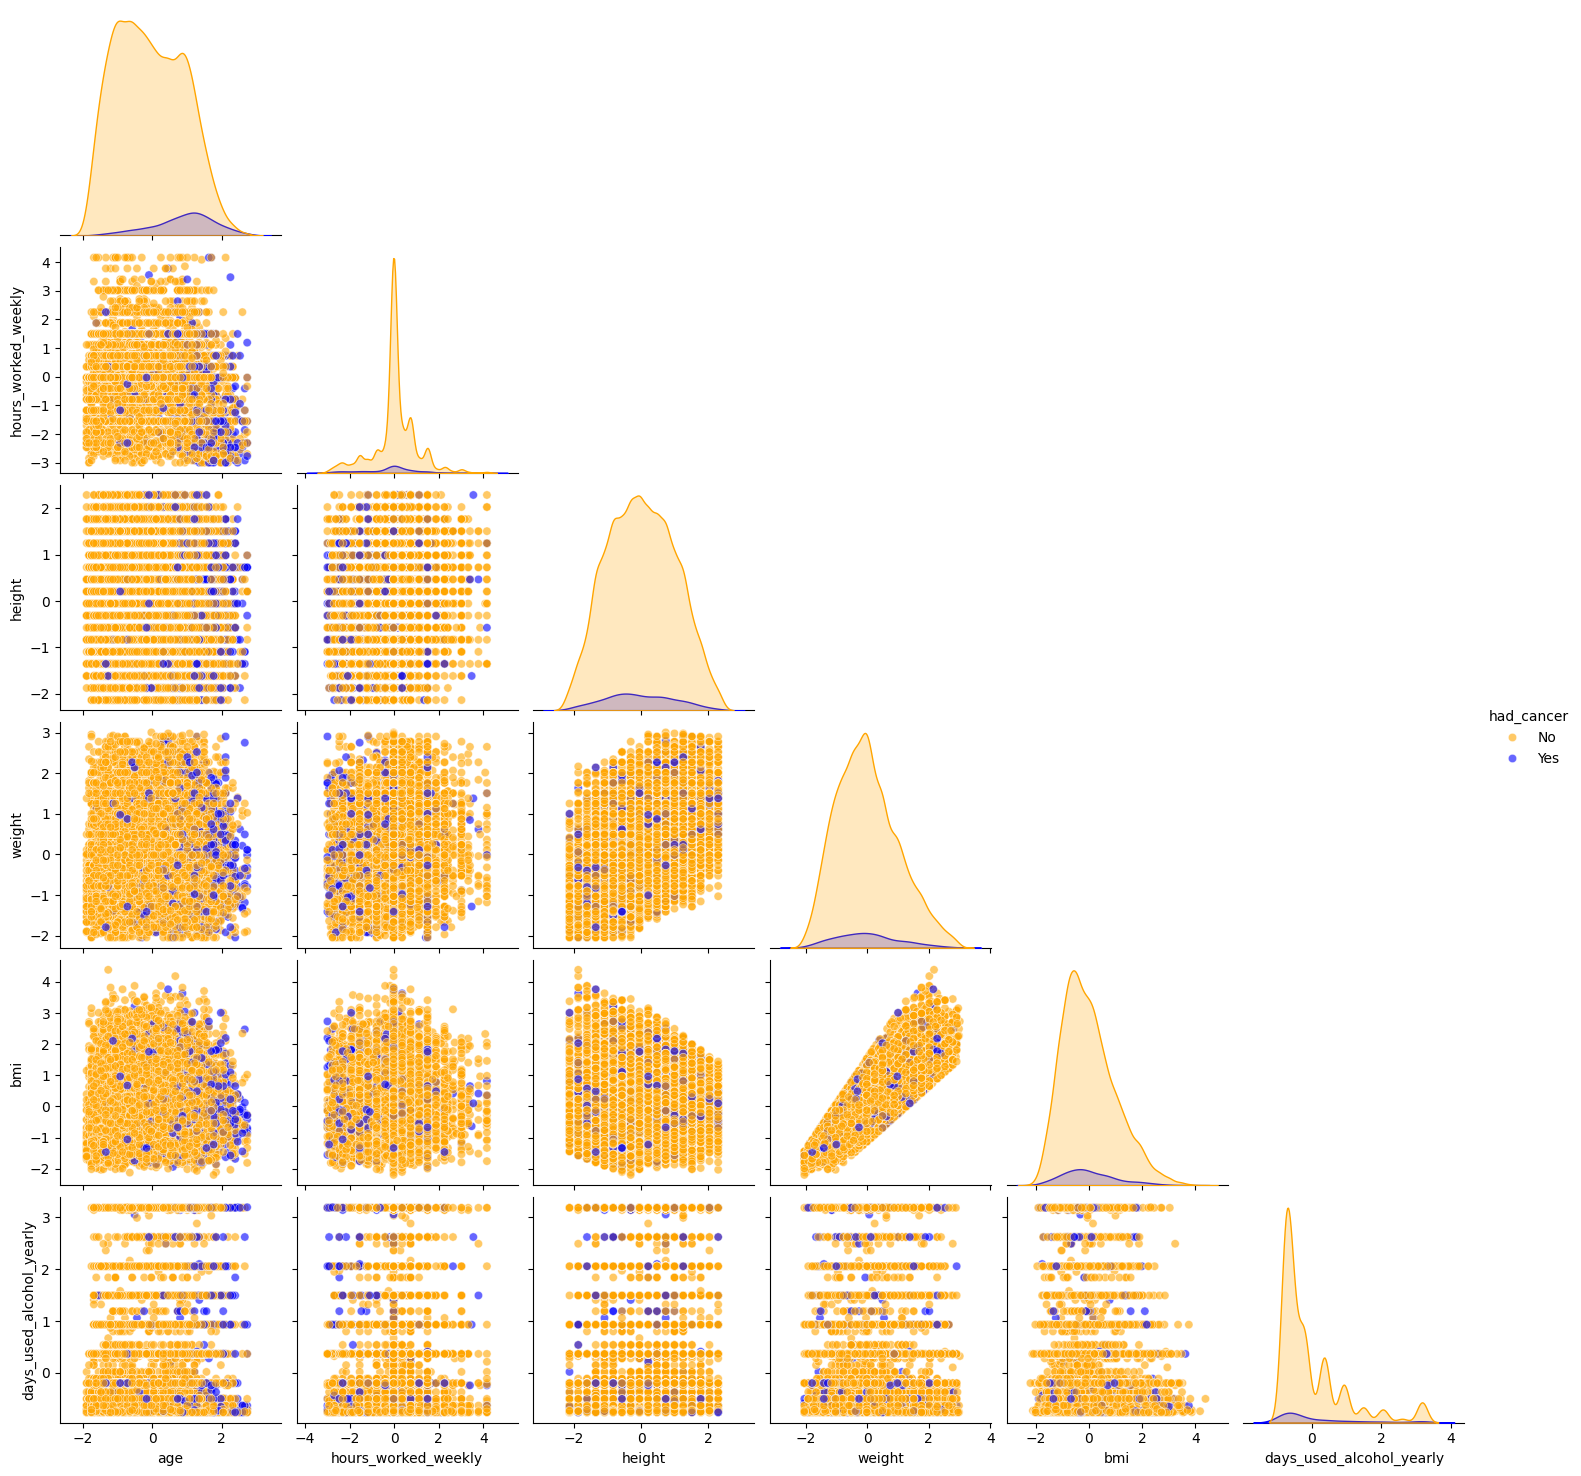

In [243]:
sns.pairplot(cancer_data, hue = "had_cancer", plot_kws={"alpha": 0.6}, corner = True, palette=["orange", "blue"])

Again, there is so much overlap between the classes that the blue points (people who've had cancer) are in the middle of the orange points (people who haven't).

Despite the overlap, there is a trend in many of the plots containing the `age` variable, where older people are more likely to have cancer. Examples of these plots are `hours_worked_weekly` vs. `age`, `height` vs. `age`, `weight` vs. `age`, `bmi` vs. `age`, and `days_used_alcohol_yearly` vs. `age`. 

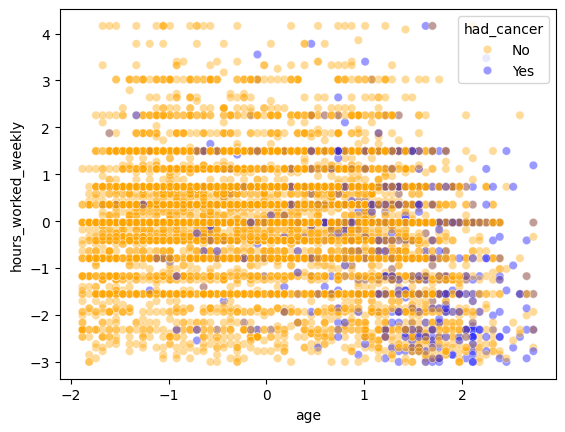

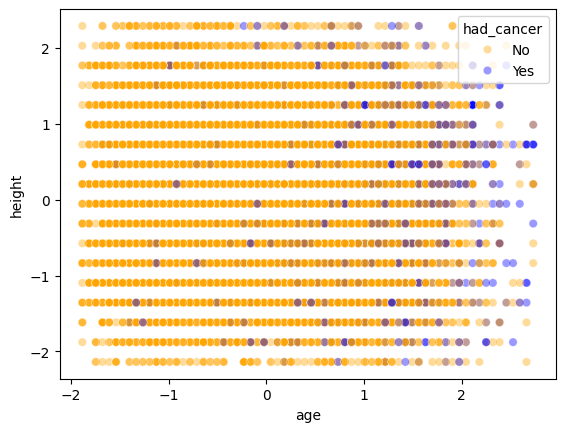

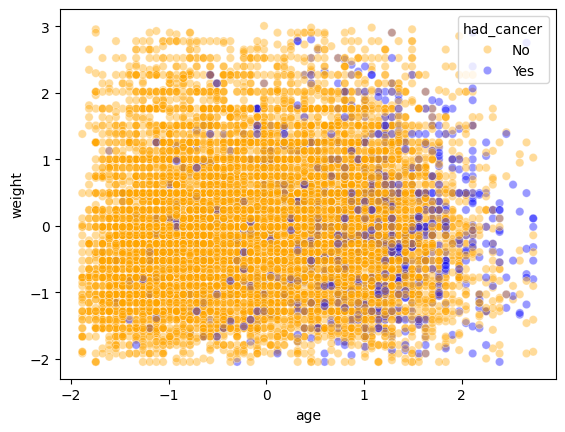

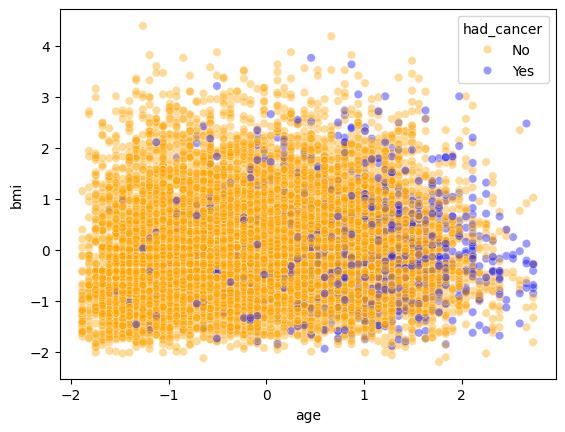

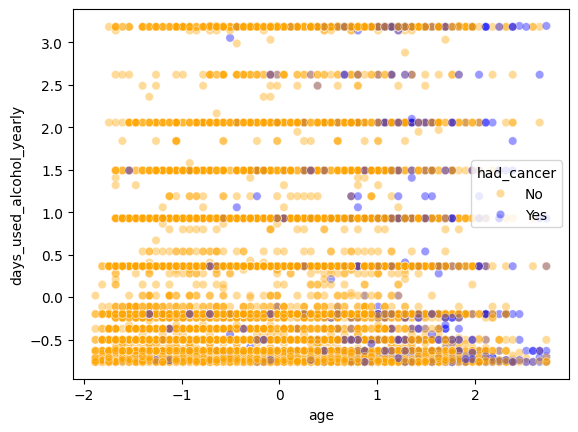

In [244]:
import matplotlib.pyplot as plt

sns.scatterplot(cancer_data, x = "age", y = "hours_worked_weekly", hue = "had_cancer", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(cancer_data, x = "age", y = "height", hue = "had_cancer", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(cancer_data, x = "age", y = "weight", hue = "had_cancer", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(cancer_data, x = "age", y = "bmi", hue = "had_cancer", palette = ["orange", "blue"], alpha=0.4)
plt.show()

sns.scatterplot(cancer_data, x = "age", y = "days_used_alcohol_yearly", hue = "had_cancer", palette = ["orange", "blue"], alpha=0.4)
plt.show()


Based on the plots above, I conclude that a nonlinear kernel would be best for separating the predictors in each plot.

Based on the plots for both diseases, I will use:
- A linear kernel to predict whether someone has had diabetes based on `bmi`, `weight`, and `age`
- A nonlinear kernel to predict whether someone has had diabetes based on `bmi`, `hours_worked_weekly`, `age`, and `height`
- A nonlinear kernel to predict whether someone has had cancer based on `age`, `hours_worked_weekly`, `height`, `weight`, `bmi`, and `days_used_alcohol_yearly`

## Create and save the final datasets

We will create and save a separate feature matrix for each of the three classification problems I described above.

In [245]:
cancer_data.to_csv("cancer_data.csv", index=False) # Feature matrix for predicting cancer

In [246]:
diabetes_data_linear = diabetes_data[["bmi", "weight", "age", "had_diabetes"]] # Feature matrix for the linear problem for diabetes
diabetes_data_linear.to_csv("diabetes_data_linear.csv", index=False)

In [247]:
diabetes_data_nonlinear = diabetes_data[["bmi", "hours_worked_weekly", "age", "height", "had_diabetes"]] # Feature matrix for the nonlinear problem for diabetes
diabetes_data_nonlinear.to_csv("diabetes_data_nonlinear.csv", index=False)